# Driving An External Program: Xfoil

---

In this example notebook we demonstrate how to interface with an external program; in this case [xfoil](https://web.mit.edu/drela/Public/web/xfoil/). We will do so by 1. Generating and writing an input file to disk, 2. Passing that input file to xfoil for execution, and 3. Loading and post-processing the generated result files. Writing a wrapper function like this allows us to use grama with external applications.


In [1]:
import grama as gr
import os
import matplotlib.pyplot as plt
import numpy as np
import subprocess

# Settings
exec_name = "xfoil"
filename_input = "input.txt"
filename_airfoil = "airfoil.txt"
filename_cp = "cp.txt"
filename_dump = "dump.txt"
numNodes = '1000'

### Build the interface

---

The following function is where all the magic happens.


In [2]:
def xfoil_cl(x):
    """Compute Cl with Xfoil
    
    Dispatches to xfoil to compute the lift coefficient
    of a given 4-Digit NACA Series airfoil.
    
    Args:
        x = [m, p, t, a]
        m (float): Maximum camber (1st digit)
        p (float): Max camber location (2nd digit)
        t (float): Thickness (3rd and 4th digits)
        a (int): Angle of attack (in degrees)
        
    Returns:
        float: Lift coefficient
    """
    m, p, t, a = x
    # Check invariants
    if not (0 <= m) and (m < 0.1):
        raise ValueError("m out of bounds [0, 1]")
    if not (0 <= p) and (p < 1):
        raise ValueError("p out of bounds [0, 1]")
    if not (0 <= t) and (t < 1):
        raise ValueError("t out of bounds [0, 1]")
    
    # Format NACA string
    NACA = '{0:d}{1:d}{2:d}'.format(
        int(100 * m),
        int(10 * p),
        int(100 * t)
    )
    # Format AoA string
    AoA = '{0:d}'.format(int(a))
    
    # Delete dangling files
    if os.path.exists(filename_airfoil):
        os.remove(filename_airfoil)
    if os.path.exists(filename_cp):
        os.remove(filename_cp)
        
    # Generate input file
    with open(filename_input, "w") as f:
        lines = [
            "NACA " + NACA,
            "PPAR",
            "N " + numNodes,
            "",
            "",
            "PSAV " + filename_airfoil,
            "OPER",
            "ALFA " + AoA,
            "CPWR " + filename_cp,
            # "DUMP " + filename_dump
        ]
        f.write('\n'.join(lines))
        
    # Run xfoil from command line, pass input file
    subprocess.call("{0:} < {1:}".format(exec_name, filename_input), shell=True)

    try:
        # Load results
        data_airfoil = np.loadtxt(filename_airfoil)
        data_cp = np.loadtxt(filename_cp, skiprows=1)
        
        # Unpack data
        X_airfoil = data_airfoil[:, 0]
        Y_airfoil = data_airfoil[:, 1]
        
        X_cp = data_cp[:, 0]
        Cp = data_cp[:, 1]
        
        # Post-process for lift coefficient
        dx_a = np.concatenate((X_airfoil[1:], [X_airfoil[0]])) - X_airfoil
        dy_a = np.concatenate((Y_airfoil[1:], [Y_airfoil[0]])) - Y_airfoil
        a_a = np.arctan2(dy_a, dx_a)
        
        return np.sum( Cp * np.cos(a_a) * np.sqrt(dx_a**2 + dy_a**2) )
    except OSError:
        return np.nan


Test the interface on a NACA 0012 at $2^{\circ}$ angle of attack.

In [3]:
xfoil_cl([0, 0, 0.12, 2])

0.23745283268822692

From the command line, xfoil returns $C_L = 0.2416$ for the lift coefficient at this setting; we may have lost a bit of precision reading from the text files and post-processing.

### Build the model

---

Xfoil will be our function, but we need bounds to complete our model. Below I choose to sweep over the geometric values, fixing an angle of attack of $5^{\circ}$.

In [4]:
md_airfoil = gr.Model("4-Series NACA") >> \
    gr.cp_function(
        fun=xfoil_cl,
        var=["m", "p", "t", "a"],
        out=["Cl"],
        name="Xfoil"
    ) >> \
    gr.cp_bounds(
        m=(0.0, 0.05),
        p=(0.1, 0.9),
        t=(0.1, 0.2),
        a=(+5, +5)
    )
    
md_airfoil.printpretty()

model: 4-Series NACA

  inputs:
    var_det:
      m: [0.0, 0.05]
      a: [5, 5]
      p: [0.1, 0.9]
      t: [0.1, 0.2]
    var_rand:
    copula:
        None
  functions:
    Xfoil: ['m', 'p', 't', 'a'] -> ['Cl']


The following call will take a little while to run, as it calls xfoil many times.

In [5]:
df_sinews = md_airfoil >> \
    gr.ev_sinews(df_det="swp", seed=101)

Once we've generated the sinews data, we can visualize the results.

Calling plot_sinew_outputs....


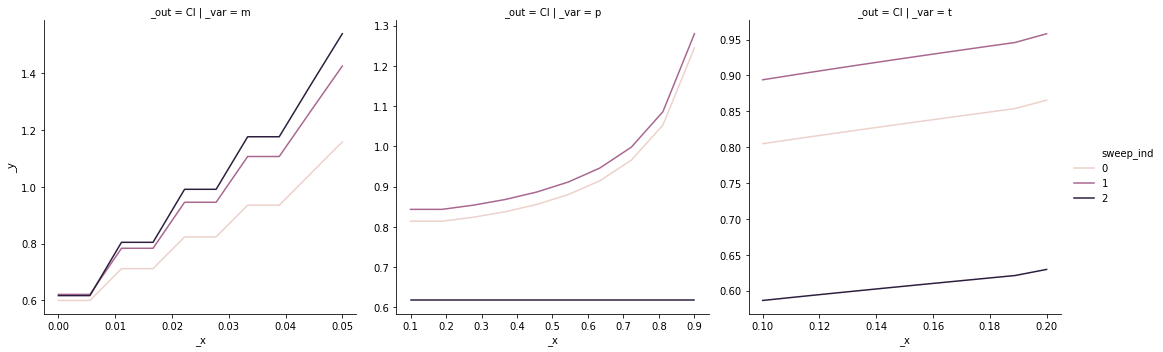

In [6]:
df_sinews >> gr.pt_auto()

Observations:

- The degree of camber `m` most strongly affects the lift
- Increasing thickness `t` weakly affects the lift
- Moving the location of max camber from fore to aft `p` increases the lift
  - The behavior in `p` is flat for `sweep_ind == 2`, however
  
Inspecting the sinew design will help us determine what happened at `sweep_ind == 2`.

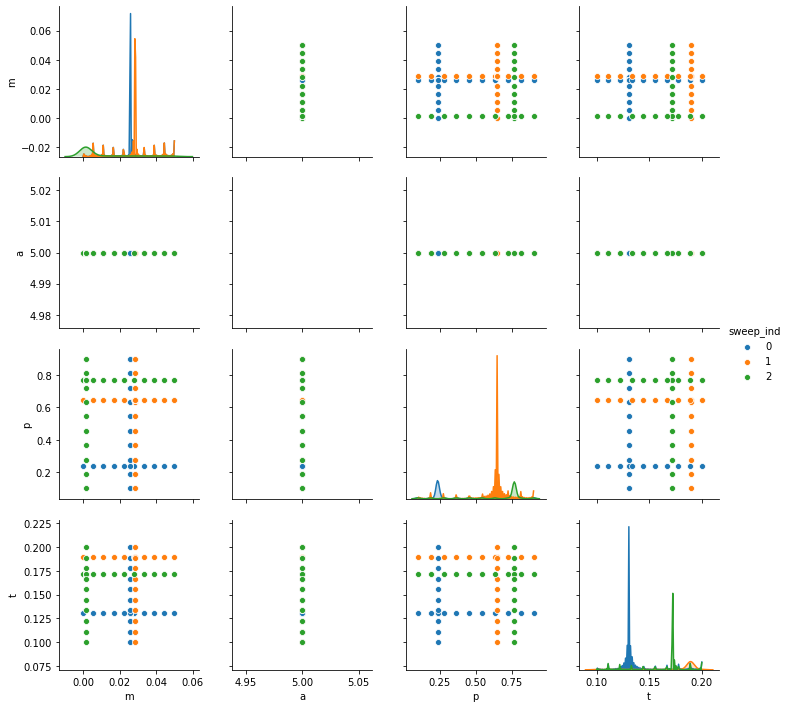

In [7]:
df_sinews >> gr.pt_sinew_inputs(var=md_airfoil.var)

We can see that `sweep_ind == 2` corresponds to `m = 0`; the location of max camber doesn't matter when there's no camber in the design! We can also see that the other two sweeps were very close in value of `m`; it is likely that `m` strongly modulates the behavior of `p`.


### Saving the results

---

Generating those results too a little time! It's a good idea to save results for later study. The following line writes the sinew data to disk for storage.


In [8]:
df_sinews.to_csv("./cl_sinews.csv")